# Enhancing Sea Ice Segmentation Model: Exploring Neural Network Ensembles and Optimization Strategies for Improved Performance
## Centro de Informática - UFPE - Introdução à Aprendizagem Profunda

**Team**:  \
Bruno Henrique dos Santos Marques (bhsm) \
José Vinicius de Santana Souza (jvss2) \
Victor Gabriel de Carvalho (vgc3)

**Professors**: \
George Darmiton da Cunha Cavalcanti \
Tsang Ing Ren


---
# Base and Pre-trained Models
## Setup

Some libraries and configurations will be needed troughout this project. Firt of all, it will be necessary to download some packages that do not come built in Google Colab.

> imagecodecs: allows Pillow to read mor image formats, such as .tiff files.

> segmentation-models-pytorch: introduces some pre-trained Pytorch segmentation models.

> tifffile: let us load easily tiff files as numpy arrays.

In [1]:
# !pip install imagecodecs -q
# !pip install segmentation-models-pytorch -q
# !pip install tifffile -q

These are all libraries that will be needed:

> os: provides a versatile interface for interacting with the operating system, allowing for operations like file and directory manipulation, path handling, and environment variables.

> shutil: complements the functionality of os by offering higher-level file operations. It simplifies tasks such as file copying, moving, and removal.

> numpy: is a fundamental library for numerical computing in Python. It provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.

> torch: is a popular open-source machine learning framework. It facilitates the development and training of deep neural networks

> torchvision: extends the capabilities of PyTorch to include computer vision tasks. It provides pre-trained models, datasets, and transformation functions.

> matplotlib: is a versatile plotting library in Python, offering a wide range of visualization tools.

> PIL: is a powerful library for opening, manipulating, and saving various image file formats.

> tdqm: adds a progress bar to loops, making it easy to track the progress of iterative tasks.

> tifffile: is designed for reading and writing TIFF (Tagged Image File Format) files. It is particularly useful in scientific and image processing applications where TIFF is a common format for storing multidimensional image data.

> segmentation_models_pytorch: introduces some pre-trained Pytorch segmentation models.

> google: provides convenient interfaces for interacting with Google services like Google Drive.

In [2]:
import os
import shutil
import numpy as np

import torch
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import matplotlib.pyplot as plt
from PIL import Image

from tqdm.auto import tqdm
import tifffile

import segmentation_models_pytorch as smp

# from google.colab import drive
# drive.mount('/content/drive')

To ensure reproducibility and experiment stability, a manual seed will be set for PyTorch. We will also use cuda (GPU) every time it is available, given that it significantly decreases the execution time for CNNs.

In [3]:
torch.manual_seed(9)
torch.cuda.manual_seed(9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
torch.cuda.set_per_process_memory_fraction(0.70, device=device)
torch.cuda.empty_cache()

---
## Dataset

This code will rely on the Leeds SciML Sea Ice Segmentation Kaggle competition dataset, in which its main objective is to generate a sea ice segmented image mask from two combined inputs.

The dataset is composed entirely by ``.tiff" images. Each data sample is separated into three different image files by its titles ending:

*   Image files with titles ending with “sar.tiff” are single-band SAR (synthetic aperture radar) images, providing useful information about the ice-water interface and its characteristics.

*   Image files with titles ending with “vis.tiff” are three-band optical images that provide visual data that will also be used as inputs as complements for the “sar.tiff” images.

* Image files with titles ending with “ref.tiff” are the ground truth label image files.

The comeptition provides those images in two files:

*   "train" is the folder that contains the data used for training the models
*   "test" is the folder that contains the data used for evaluate the trained models, and each data is separated into two image files. There is no reference images.



In [5]:
# PATH = '/content/drive/MyDrive/Introdução à Aprendizagem Profunda/IDL - Projeto/sciml'  # Path CIn
# PATH = '/content/drive/MyDrive/Deep Learning/IDL - Projeto/sciml'  # Path UFPE
# PATH = '/content/drive/MyDrive/UFPE/IDL - Projeto/sciml'  # Path Private
PATH = 'sciml'  # Path Local
train_path = f'{PATH}/train'
test_path = f'{PATH}/test'

path_train_ref = f"{PATH}/train_ref"
path_train_sar = f"{PATH}/train_sar"
path_train_vis = f"{PATH}/train_vis"

path_test_ref = f"{PATH}/test_ref"
path_test_sar = f"{PATH}/test_sar"
path_test_vis = f"{PATH}/test_vis"

The code below was only needed once because it only served to rearrange the dataset structure.

In [6]:
# diretorio_ref = f"{PATH}/train_ref"
# diretorio_sar = f"{PATH}/train_sar"
# diretorio_vis = f"{PATH}/train_vis"

# # Percorre todos os arquivos no diretório de origem
# for root, dirs, files in os.walk(train_path):
#     for file in files:
#         if file.endswith("ref.tiff"):
#             # Copia para a pasta ref
#             shutil.copy(os.path.join(root, file), os.path.join(diretorio_ref, file))
#         elif file.endswith("sar.tiff"):
#             # Copia para a pasta sar
#             shutil.copy(os.path.join(root, file), os.path.join(diretorio_sar, file))
#         elif file.endswith("vis.tiff"):
#             # Copia para a pasta vis
#             shutil.copy(os.path.join(root, file), os.path.join(diretorio_vis, file))
# print("Arquivos copiados com sucesso!")

# diretorio_ref = f"{PATH}/test_ref"
# diretorio_sar = f"{PATH}/test_sar"
# diretorio_vis = f"{PATH}/test_vis"

# # Percorre todos os arquivos no diretório de origem
# for root, dirs, files in os.walk(test_path):
#     for file in files:
#         if file.endswith("ref.tiff"):
#             # Copia para a pasta ref
#             shutil.copy(os.path.join(root, file), os.path.join(diretorio_ref, file))
#         elif file.endswith("sar.tiff"):
#             # Copia para a pasta sar
#             shutil.copy(os.path.join(root, file), os.path.join(diretorio_sar, file))
#         elif file.endswith("vis.tiff"):
#             # Copia para a pasta vis
#             shutil.copy(os.path.join(root, file), os.path.join(diretorio_vis, file))
# print("Arquivos copiados com sucesso!")

The only two transformations applied to our dataset will be a resize to 576x576 pixels (the original size used in UNet) and a datatype conversion to PyTorch tensor.

In [7]:
data_transforms = v2.Compose([
    v2.ToImage(), v2.ToDtype(torch.float32, scale=False),
    # v2.Resize((576, 576), antialias=False),
    v2.Resize((384, 384), antialias=False),
])

train_transforms = v2.Compose([
    v2.ToImage(), v2.ToDtype(torch.float32, scale=False),
    # v2.Resize((576, 576), antialias=False),
    v2.Resize((384, 384), antialias=False),
    # v2.RandomCrop((256, 256)),
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip(),
])

class MyDataset(Dataset):
    def __init__(self, ref_path, sar_path, vis_path, transforms=None):
        self.ref_path = ref_path
        self.sar_path = sar_path
        self.vis_path = vis_path

        self.transforms = transforms
        self.norm = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        self.ref_files = os.listdir(ref_path)
        self.len_ref = len(self.ref_files)
        self.sar_files = os.listdir(sar_path)
        self.vis_files = os.listdir(vis_path)

    def __len__(self):
        return len(self.vis_files)

    def __getitem__(self, index):
        vis_path = os.path.join(self.vis_path, self.vis_files[index])
        ref_path = os.path.join(self.ref_path, self.vis_files[index].replace('vis', 'ref')) if (self.len_ref > 0) else None
        sar_path = os.path.join(self.sar_path, self.vis_files[index].replace('vis', 'sar'))

        # vis_image = Image.open(vis_path).convert("RGB")
        sar_image = Image.open(sar_path)
        ref_image = Image.open(ref_path).convert("L") if (self.len_ref > 0) else None

        vis_image = tifffile.imread(vis_path)
        # sar_image = tifffile.imread(sar_path)
        # ref_image = tifffile.imread(ref_path)

        if self.transforms:
            vis_image = self.transforms(vis_image)
            sar_image = self.transforms(sar_image)
            ref_image = self.transforms(ref_image) if (self.len_ref > 0) else None

        #print(vis_image.shape, sar_image.shape)
        input_image = torch.cat((vis_image, sar_image), 0)
        ref_image = ref_image if (self.len_ref > 0) else torch.zeros_like(sar_image)
        
        if (self.len_ref > 0):
            ref_image = np.array(ref_image)
            ref_image = np.where((ref_image<0.5), 0, 1)
            ref_image = torch.tensor(ref_image, dtype=torch.float32)

        return input_image, ref_image

Here the tadasets and dataloaders are instantianted. We created a train, validation and test loader. A batch size of 4 was chosen to use the most of our hardware.

In [8]:
# BATCH_SIZE = 4
BATCH_SIZE = 2

train_dataset = MyDataset(path_train_ref, path_train_sar, path_train_vis, data_transforms)
test_dataset = MyDataset(path_test_ref, path_test_sar, path_test_vis, data_transforms)

num_samples = len(train_dataset)
indices = list(range(num_samples))

split_ratio = 0.8
split_idx = int(num_samples * split_ratio)

train_indices, val_indices = indices[:split_idx], indices[split_idx:]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

len(train_dataset), len (test_dataset)

(1407, 352)

Below, it is shown a batch of samples (vis, sar and ref) from the training loader.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


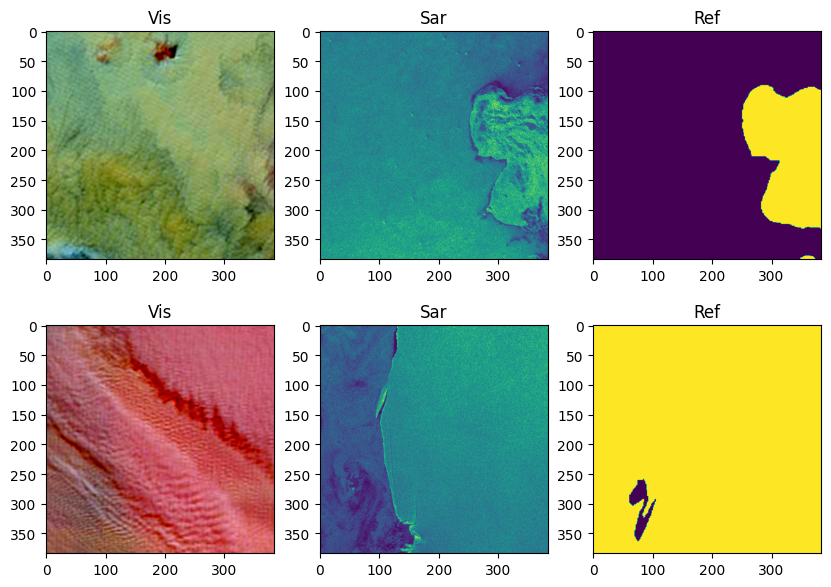

In [9]:
it = iter(train_loader)
image, label = next(it)

unnormalize = v2.Compose([
    v2.Normalize((0.0, 0.0, 0.0), (1/0.229, 1/0.224, 1/0.225)),
    v2.Normalize((-0.485, -0.456, -0.406), (1.0, 1.0, 1.0)),
])

fig, ax = plt.subplots(BATCH_SIZE, 3, figsize=(10, 7))
for idx in range(BATCH_SIZE):
    ax[idx][0].set_title("Vis")
    ax[idx][1].set_title("Sar")
    ax[idx][2].set_title("Ref")

    a = label[idx]*255
    ax[idx][0].imshow(image[idx][0:3, :, :].cpu().permute(1, 2, 0))
    ax[idx][1].imshow(image[idx][3:, :, :].cpu().permute(1, 2, 0))
    ax[idx][2].imshow(a.cpu().permute(1, 2, 0))

---
## Model

UNet, renowned for its prowess in image segmentation tasks, consists of an encoder-decoder architecture with skip connections, allowing for the precise localization of features.

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(UNet, self).__init__()
        self.feat_list = [64, 128, 256, 512]

        self.down = nn.ModuleList()
        self.down.append(DoubleConv(in_channels=in_channels, out_channels=self.feat_list[0]))
        for features in self.feat_list[:-1]:
            self.down.append(DoubleConv(in_channels=features, out_channels=(features*2)))

        self.up = nn.ModuleList()
        for features in reversed(self.feat_list):
            self.up.append(nn.ConvTranspose2d(in_channels=(features*2), out_channels=features, kernel_size=2, stride=2))
            self.up.append(DoubleConv(in_channels=(features*2), out_channels=features))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bot = DoubleConv(in_channels=self.feat_list[-1], out_channels=(self.feat_list[-1]*2))
        self.final = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        interm_reps = []
        for down_layer in self.down:
            x = down_layer(x)
            interm_reps.append(x)
            x = self.pool(x)

        x = self.bot(x)

        for up_layer in self.up:
            x = up_layer(x)
            if not isinstance(up_layer, DoubleConv):
                rep = interm_reps.pop()
                if x.shape != rep.shape:
                    resize = v2.Resize(rep.shape[2:], antialias=True)
                    x = resize(x)

                x = torch.cat((rep, x), dim=1)

        return self.final(x)

    def predict(self, x):
        return self.forward(x)


Consider this model our base model. We will compare the optimizations and variations with it.

Our loss function will be Binary Cross Entropy with Logits Loss. In the context of binary image segmentation, where the goal is to classify each pixel as either foreground or background, this loss function is well-suited. It combines a sigmoid activation function and the binary cross-entropy loss.

The Adam optimizer is also uded. It is a popular choice due to its adaptive learning rate mechanism. The optimizer takes the model parameters and adjusts them based on the gradients computed during backpropagation.

In [11]:
base_model = UNet(in_channels=4, out_channels=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.0001)

base_model

UNet(
  (down): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): DoubleC

---
## Training

Below, we create the train and test functions, that will be used throughout our implementation. The train function establishes a default patience criteria of 3 iterations and sets the model to its best state (lower loss in validation) after that.

In [12]:
def train(model, train_loader, val_loader, max_epochs, loss_fn, optimizer, patience=3, plot=True):
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []

    best_model_state = model.state_dict()
    best_val_loss = float('inf')
    counter = 0
    for epoch in range(1, max_epochs+1):
        train_loss = 0.0
        for (images, labels) in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            model.train()
            y_pred = model(images)

            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = 0.0
        model.eval()
        with torch.inference_mode():
            for (images, labels) in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)

                y_val_pred = model(images)
                val_loss += loss_fn(y_val_pred, labels).item()

            val_loss /= len(val_loader)
            val_loss_list.append(val_loss)

        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)
        print(f"{epoch:02d}: Train loss: {train_loss:.5f} | Validation loss: {val_loss:.5f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}, the model will be set to its best state.")
                break

    model.load_state_dict(best_model_state)

    # Plotting Results
    if plot:
        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot(train_loss_list, label='Train loss')
        ax.plot(val_loss_list, label='Validation loss:')
        ax.set_title("Loss value during training")
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss (Binary Cross Entropy)')
        ax.legend()
        
    return model


def test(model, test_loader, loss_fn):
    test_loss = 0.0
    y_pred = []
    y_true = []
    model.eval()
    with torch.inference_mode():
        for (images, labels) in tqdm(test_loader):
            if labels is not None:
                images, labels = images.to(device), labels.to(device)

                y_test_pred_logits = model(images)
                test_loss += loss_fn(y_test_pred_logits, labels).item()

                y_test_pred = model.predict(images)
                y_pred.extend(y_test_pred.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
            else:
                print('There are no labels')
                break

        test_loss /= len(test_loader)

    return y_pred, y_true, test_loss

Our first model will be trained during, at most, 20 epochs (it will likely early stop before) and tested on the validation dataset.

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

01: Train loss: 0.48878 | Validation loss: 0.29373


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

02: Train loss: 0.42341 | Validation loss: 0.27017


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

03: Train loss: 0.38760 | Validation loss: 0.25722


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

04: Train loss: 0.34295 | Validation loss: 0.27804


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

05: Train loss: 0.31547 | Validation loss: 0.31979


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

06: Train loss: 0.28943 | Validation loss: 0.32456
Early stopping at epoch 6, the model will be set to its best state.


  0%|          | 0/141 [00:00<?, ?it/s]

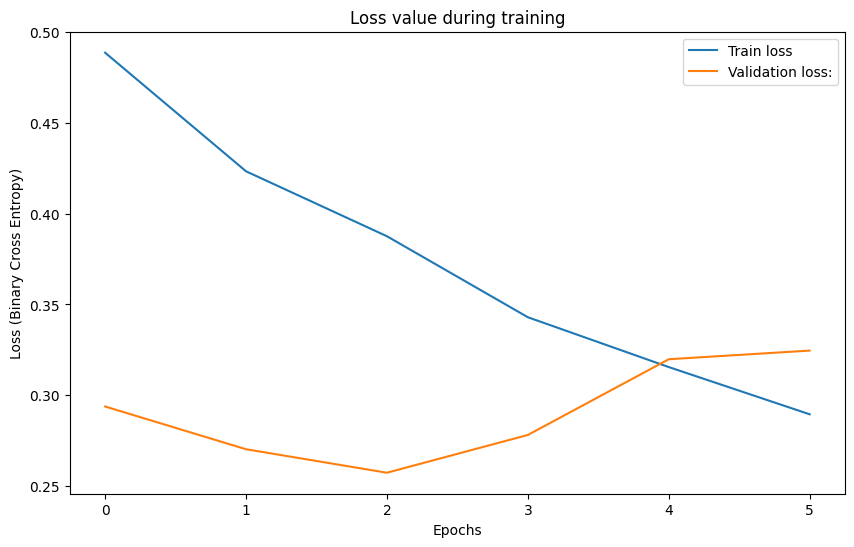

In [13]:
max_epochs = 20
base_model = train(base_model, train_loader, val_loader, max_epochs, loss_fn, optimizer)

y_pred, y_true, base_val_loss = test(base_model, val_loader, loss_fn)

---
## Evaluation

The following metrics will be used to evaluate each model approach:

* Intersection over Union (IoU) is one of the most used image segmentation metrics. It consists in quantifying how well the model can distinguish objects from their backgrounds in an image.

* Dice Coefficient is a similarity metric that acts between two sets. In our case, it will check the similarity between our reference and our predicted image.

* Pixel Accuracy measures the overall accuracy of pixel-wise predictions. It is a really simple and straightforward approach.

In [14]:
def iou_score(predictions, targets):
    predictions = (predictions > 0.5).float()
    predictions_flat = predictions.view(-1)
    targets_flat = targets.view(-1)
    intersection = torch.sum(predictions_flat * targets_flat)
    union = torch.sum(predictions_flat) + torch.sum(targets_flat) - intersection
    iou = intersection / (union + 1e-8)
    return iou.item()


def dice_coefficient(predicted, target):
    intersection = torch.sum(predicted * target) * 2.0
    union = torch.sum(predicted) + torch.sum(target)
    dice = intersection / (union + 1e-8)
    return dice.item()


def pixel_accuracy(predicted, target):
    correct_pixels = torch.sum(predicted == target).item()
    total_pixels = target.numel()
    accuracy = correct_pixels / total_pixels
    return accuracy


def evaluate(model, test_loader):
    all_iou = []
    all_dice = []
    all_pa = []

    model.eval()
    with torch.inference_mode():
        for images, masks in tqdm(test_loader):
            images, masks = images.to(device), masks.to(device)

            # predictions = model.predict(images)
            outputs = model(images)
            predictions = torch.sigmoid(outputs)
            predictions = (predictions > 0.5).float()

            iou = iou_score(predictions, masks)
            all_iou.append(iou)
            dice = dice_coefficient(predictions, masks)
            all_dice.append(dice)
            pa = pixel_accuracy(predictions, masks)
            all_pa.append(pa)

        average_dice = sum(all_dice) / len(all_dice)
        average_iou = sum(all_iou) / len(all_iou)
        average_pa = sum(all_pa) / len(all_pa)

    print(f'Average IoU: {average_iou:.4f}')
    print(f'Average Dice Coefficient: {average_dice:.4f}')
    print(f'Average Pixel Accuracy: {average_pa:.4f}')

    return average_iou, average_dice, average_pa


def evaluate_ensemble(predictions, masks):
    iou = iou_score(predictions, masks)
    dice = dice_coefficient(predictions, masks)
    pa = pixel_accuracy(predictions, masks)

    return iou, dice, pa

The following lists will be used for later analysis..

In [15]:
model_name = []
eval_iou = []
eval_dice = []
eval_pa = []
eval_val_loss = []

The results for our first model are shown below

In [16]:
base_iou, base_dice, base_pa = evaluate(base_model, val_loader)
model_name.append('Base Model')
eval_iou.append(base_iou)
eval_dice.append(base_dice)
eval_pa.append(base_pa)
eval_val_loss.append(base_val_loss)

  0%|          | 0/141 [00:00<?, ?it/s]

Average IoU: 0.7229
Average Dice Coefficient: 0.7924
Average Pixel Accuracy: 0.7890


In [17]:
def show_visualization(input_data, model_output, num_images=2, threshold=0.5):
    input_data = input_data.cpu().detach()
    model_output = model_output.cpu().detach()
    binary_predictions = (model_output > threshold)
    
    fig, ax = plt.subplots(num_images, 3, figsize=(10, 7))
    for idx in range(num_images):
        input_image = input_data[idx][0:3, :, :]
        ax[idx][0].imshow(input_image.permute(1, 2, 0))
        
        input_image = input_data[idx][3:, :, :]
        ax[idx][1].imshow(input_image.permute(1, 2, 0))

        output_image = binary_predictions[idx][0, :, :] 
        ax[idx][2].imshow(output_image)
        
    torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


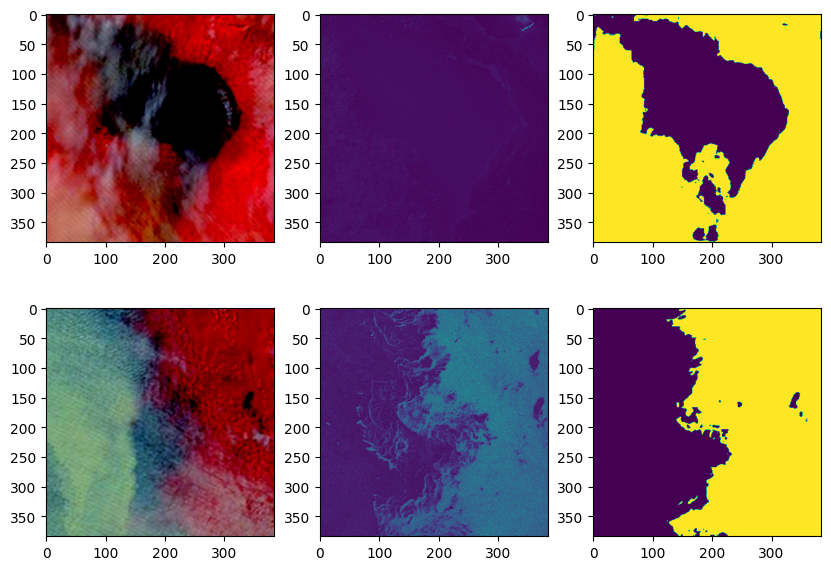

In [18]:
images, _ = next(iter(test_loader))

base_model.eval()
with torch.inference_mode():
    outputs = base_model(images.to(device))
    show_visualization(images, outputs)

---
## Pre-Trained Model

Our first model variation will be this pre-trained approach. It encodes the images using a ResNet50 trained on the ImageNet dataset. The loss fiction and optimizer will remain the same.

In [19]:
pre50_model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet",
                     in_channels=4, classes=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(pre50_model.parameters(), lr=0.0001)

pre50_model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

01: Train loss: 0.51834 | Validation loss: 0.34152


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

02: Train loss: 0.41284 | Validation loss: 0.28111


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

03: Train loss: 0.31710 | Validation loss: 0.24617


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

04: Train loss: 0.28376 | Validation loss: 0.27842


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

05: Train loss: 0.26668 | Validation loss: 0.25166


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

06: Train loss: 0.24288 | Validation loss: 0.20781


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

07: Train loss: 0.22779 | Validation loss: 0.37508


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

08: Train loss: 0.20203 | Validation loss: 0.21632


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

09: Train loss: 0.21291 | Validation loss: 0.29048
Early stopping at epoch 9, the model will be set to its best state.


  0%|          | 0/141 [00:00<?, ?it/s]

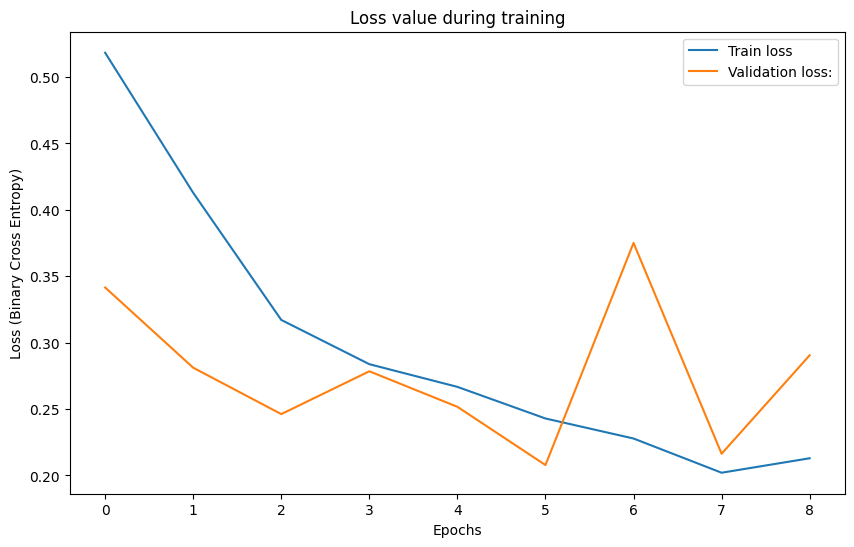

In [20]:
max_epochs = 20
pre50_model = train(pre50_model, train_loader, val_loader, max_epochs, loss_fn, optimizer)

y_pred, y_true, pre50_val_loss = test(pre50_model, val_loader, loss_fn)

Here are the results of our second model.

In [21]:
pre_iou, pre_dice, pre_pa = evaluate(pre50_model, val_loader)
model_name.append('Pre-trained Model (ResNet50)')
eval_iou.append(pre_iou)
eval_dice.append(pre_dice)
eval_pa.append(pre_pa)
eval_val_loss.append(pre50_val_loss)

  0%|          | 0/141 [00:00<?, ?it/s]

Average IoU: 0.7538
Average Dice Coefficient: 0.8215
Average Pixel Accuracy: 0.8364


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


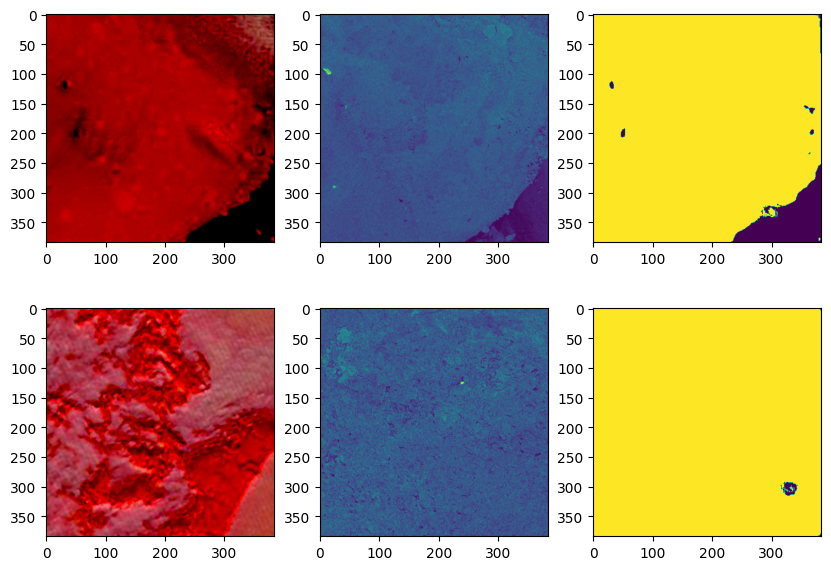

In [22]:
images, _ = next(iter(test_loader))

pre50_model.eval()
with torch.inference_mode():
    outputs = pre50_model(images.to(device))
    show_visualization(images, outputs)

---

In [23]:
pre34_model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet",
                     in_channels=4, classes=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(pre34_model.parameters(), lr=0.0001)

pre34_model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

01: Train loss: 0.51567 | Validation loss: 0.41601


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

02: Train loss: 0.39803 | Validation loss: 0.49242


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

03: Train loss: 0.34051 | Validation loss: 0.25169


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

04: Train loss: 0.31414 | Validation loss: 0.24389


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

05: Train loss: 0.26493 | Validation loss: 0.68026


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

06: Train loss: 0.24558 | Validation loss: 0.33041


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

07: Train loss: 0.24127 | Validation loss: 0.22442


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

08: Train loss: 0.21098 | Validation loss: 0.29327


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

09: Train loss: 0.21231 | Validation loss: 0.28021


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

10: Train loss: 0.20496 | Validation loss: 0.49510
Early stopping at epoch 10, the model will be set to its best state.


  0%|          | 0/141 [00:00<?, ?it/s]

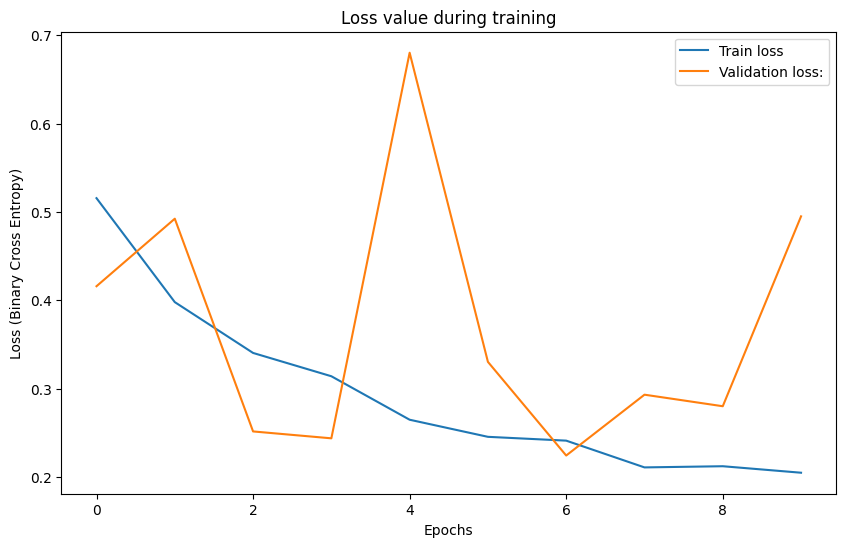

In [24]:
max_epochs = 20
pre34_model = train(pre34_model, train_loader, val_loader, max_epochs, loss_fn, optimizer)

y_pred, y_true, pre34_val_loss = test(pre34_model, val_loader, loss_fn)

In [25]:
pre_iou, pre_dice, pre_pa = evaluate(pre34_model, val_loader)
model_name.append('Pre-trained Model (ResNet34)')
eval_iou.append(pre_iou)
eval_dice.append(pre_dice)
eval_pa.append(pre_pa)
eval_val_loss.append(pre34_val_loss)

  0%|          | 0/141 [00:00<?, ?it/s]

Average IoU: 0.6949
Average Dice Coefficient: 0.7748
Average Pixel Accuracy: 0.7598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


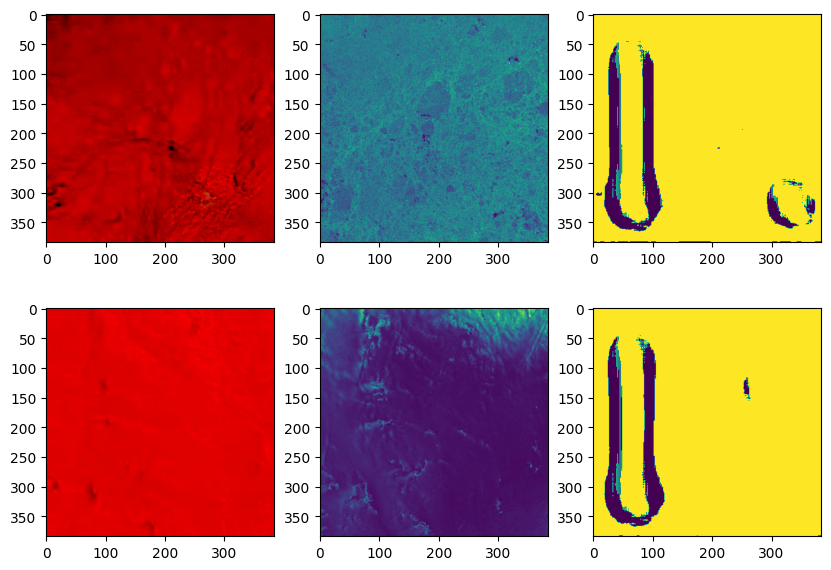

In [26]:
images, _ = next(iter(test_loader))

pre34_model.eval()
with torch.inference_mode():
    outputs = pre34_model(images.to(device))
    show_visualization(images, outputs)

---

In [27]:
pre18_model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet",
                     in_channels=4, classes=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(pre18_model.parameters(), lr=0.0001)

pre18_model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

01: Train loss: 0.52946 | Validation loss: 0.27785


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

02: Train loss: 0.41650 | Validation loss: 0.35136


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

03: Train loss: 0.35603 | Validation loss: 0.26863


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

04: Train loss: 0.28884 | Validation loss: 0.29495


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

05: Train loss: 0.27864 | Validation loss: 0.26021


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

06: Train loss: 0.25590 | Validation loss: 0.25808


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

07: Train loss: 0.22513 | Validation loss: 0.19828


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

08: Train loss: 0.21964 | Validation loss: 0.21946


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

09: Train loss: 0.18751 | Validation loss: 0.19812


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

10: Train loss: 0.17177 | Validation loss: 0.31365


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

11: Train loss: 0.20391 | Validation loss: 0.18418


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

12: Train loss: 0.16470 | Validation loss: 0.24455


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

13: Train loss: 0.15331 | Validation loss: 0.23794


  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

14: Train loss: 0.14180 | Validation loss: 0.31511
Early stopping at epoch 14, the model will be set to its best state.


  0%|          | 0/141 [00:00<?, ?it/s]

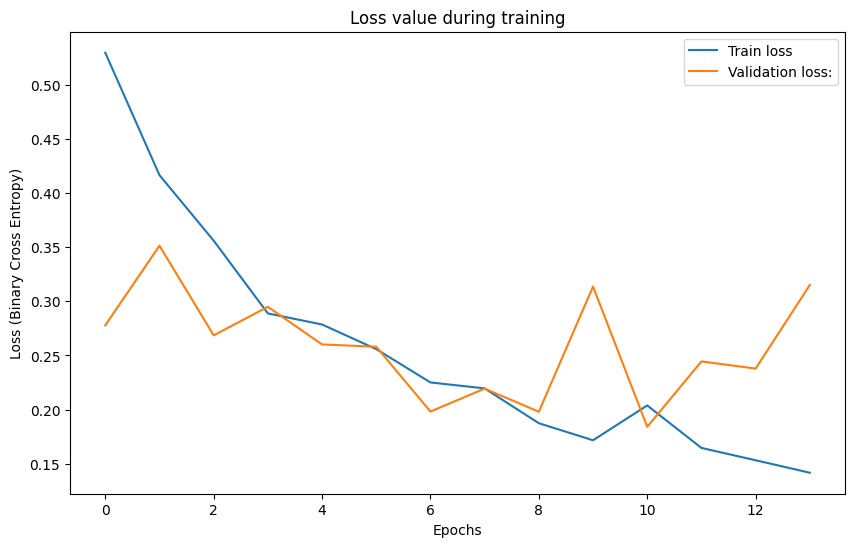

In [28]:
max_epochs = 20
pre18_model = train(pre18_model, train_loader, val_loader, max_epochs, loss_fn, optimizer)

y_pred, y_true, pre18_val_loss = test(pre18_model, val_loader, loss_fn)

In [29]:
pre_iou, pre_dice, pre_pa = evaluate(pre18_model, val_loader)
model_name.append('Pre-trained Model (ResNet18)')
eval_iou.append(pre_iou)
eval_dice.append(pre_dice)
eval_pa.append(pre_pa)
eval_val_loss.append(pre18_val_loss)

  0%|          | 0/141 [00:00<?, ?it/s]

Average IoU: 0.7243
Average Dice Coefficient: 0.7970
Average Pixel Accuracy: 0.7832


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


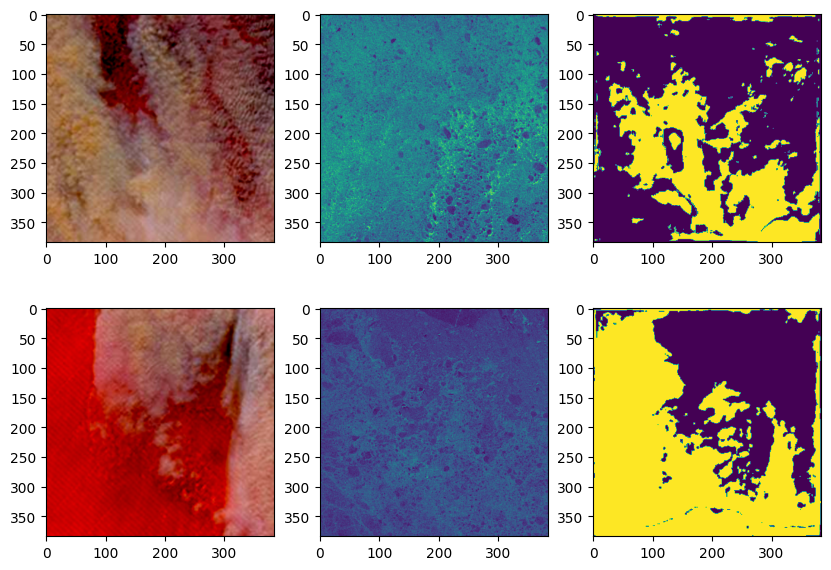

In [30]:
images, _ = next(iter(test_loader))

pre18_model.eval()
with torch.inference_mode():
    outputs = pre18_model(images.to(device))
    show_visualization(images, outputs)

---
## Performance Comparison
This data will be used in "Performance Comparison" notebook.

In [31]:
model_name, eval_iou, eval_dice, eval_pa, eval_val_loss

(['Base Model',
  'Pre-trained Model (ResNet50)',
  'Pre-trained Model (ResNet34)',
  'Pre-trained Model (ResNet18)'],
 [0.7229401609672115,
  0.7537551669152915,
  0.6949095116789512,
  0.7242910057175839],
 [0.7924280002125348,
  0.8215480996593041,
  0.7747705688449085,
  0.7969767387381735],
 [0.7889917251911572,
  0.8363684255180629,
  0.7597964792574737,
  0.7832317186961313],
 [0.3245591162208547,
  0.2904753367340602,
  0.49509534556814966,
  0.31510695699744373])

In [32]:
import csv
data = list(zip(model_name, eval_iou, eval_dice, eval_pa, eval_val_loss))
csv_file_path = 'evaluation_results.csv'

with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['MODEL','IOU', 'Dice', 'PA', 'VAL_LOSS'])
    csv_writer.writerows(data)

print(f'Data has been saved to {csv_file_path}')

Data has been saved to evaluation_results.csv


In [33]:
torch.cuda.empty_cache()

---
## References
https://www.kaggle.com/competitions/leeds-sciml-sea-ice-segmentation

https://github.com/milesial/Pytorch-UNet/tree/master

https://smp.readthedocs.io/en/latest/models.html